In [1]:
#@title Preparing Data
from google3.pyglib import gfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


exclusion_list = ['p4', 'p14', 'p16'] #@param
is_window_normalization = True #@param{type: "boolean"}

# Function to load and preprocess the dataset for CNN input, with subfolder-specific labeling
def normalize(raw_data):
  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / std
  return normalized_data

def load_and_preprocess_data(data_path):
    data = []
    labels = []
    users = []
    sessions = []

    # Walk through the folder structure
    for participant_folder in gfile.ListDir(data_path):
        participant_path = os.path.join(data_path, participant_folder)
        user = os.path.basename(participant_path)
        if user in exclusion_list:
          continue
        if gfile.IsDirectory(participant_path):
            # Go through each gesture folder
            for session_folder in gfile.ListDir(participant_path):
                session = session_folder.split('_')[-1]
                session_path = os.path.join(participant_path, session_folder)

                gesture_labels = []
                for gesture_folder in gfile.ListDir(session_path):
                    gesture_path = os.path.join(session_path, gesture_folder)
                    gesture_label = gesture_folder
                    if gesture_folder.endswith('p'):
                      for sub_gesture_folder in gfile.ListDir(gesture_path):
                        sub_gesture_label = gesture_label
                        if "start" in sub_gesture_folder:
                          sub_gesture_label += 's'
                        elif "release" in sub_gesture_folder:
                          sub_gesture_label += 'r'
                        sub_gesture_path = os.path.join(gesture_path, sub_gesture_folder)
                        gesture_labels.append((sub_gesture_label, sub_gesture_path))
                    else:
                      gesture_labels.append((gesture_label, gesture_path))
                for gesture_label, gesture_path in gesture_labels:
                    if gfile.IsDirectory(gesture_path):
                      npy_files = []
                      for pattern in ['/*.npy', '/*/*.npy']:
                        npy_files.extend(gfile.Glob(gesture_path+pattern))
                      real = np.array([])
                      imag = np.array([])
                      for npy_file in npy_files:
                        if 'real' in npy_file:
                          with gfile.Open(npy_file, 'rb') as f:
                            real = np.load(f)
                        elif 'imag' in npy_file:
                          with gfile.Open(npy_file, 'rb') as f:
                            imag = np.load(f)
                      if gesture_label == 'ip':
                          print(user, session)
                          continue
                      # real_normalized = normalize(real)
                      # imag_normalized = normalize(imag)
                      for window_i in range(real.shape[0]):
                        window_data = np.concatenate([real[window_i, :, :], imag[window_i, :, :]], axis=1)
                        if is_window_normalization:
                          window_data = normalize(window_data)

                        # Append data and corresponding label
                        data.append(window_data)
                        labels.append(gesture_label)
                        users.append(user)
                        sessions.append(session)

                        # end of window
                      # end of gesture
    return np.array(data), np.array(labels), np.array(users), np.array(sessions)

# Path to the extracted dataset
data_path = '/x20/users/ca/cadyxu/eit/microgesture'

# Load and preprocess the data
data, labels, users, sessions = load_and_preprocess_data(data_path)
print(data.shape)
label_set = np.unique(labels)
print(label_set)
print(np.unique(users))
print(np.unique(sessions))

# Convert labels to indices
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
indexed_labels = np.array([label_to_index[label] for label in labels])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, indexed_labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_to_index))
y_test = to_categorical(y_test, num_classes=len(label_to_index))



2024-09-10 06:38:00.492692: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 06:38:00.496824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 06:38:00.510256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 06:38:00.531883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 06:38:00.538326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 06:38:00.554085: I tensorflow/core/platform/cpu_feature_gu

(35871, 60, 12)
['id' 'ipr' 'ips' 'mpr' 'mps' 'sl' 'sr']
['p1' 'p10' 'p11' 'p12' 'p13' 'p15' 'p17' 'p18' 'p2' 'p3' 'p5' 'p6' 'p7'
 'p8' 'p9']
['1' '2' '3' 'idle' 'sl' 'sr']


In [ ]:
#@title CNN Modeling - 80/20

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,
12)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_set), activation='softmax'))


# Define the path to save the best model
checkpoint_filepath = '/tmp/best_model.h5'

# Create a ModelCheckpoint callback to save the model with the lowest validation loss
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
    verbose=1,
    save_best_only=True,
    mode='max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

Epoch 1/100
961/961 [==============================] - ETA: 0s - loss: 1.5160 - accuracy: 0.4055
Epoch 1: val_accuracy improved from -inf to 0.56940, saving model to /tmp/best_model.h5
961/961 [==============================] - 6s 4ms/step - loss: 1.5160 - accuracy: 0.4055 - val_loss: 1.0750 - val_accuracy: 0.5694
Epoch 2/100
952/961 [============================>.] - ETA: 0s - loss: 1.0196 - accuracy: 0.6049
Epoch 2: val_accuracy improved from 0.56940 to 0.70743, saving model to /tmp/best_model.h5
961/961 [==============================] - 4s 4ms/step - loss: 1.0183 - accuracy: 0.6055 - val_loss: 0.8127 - val_accuracy: 0.7074
Epoch 3/100
959/961 [============================>.] - ETA: 0s - loss: 0.8214 - accuracy: 0.6868
Epoch 3: val_accuracy improved from 0.70743 to 0.75946, saving model to /tmp/best_model.h5
961/961 [==============================] - 4s 4ms/step - loss: 0.8210 - accuracy: 0.6868 - val_loss: 0.6489 - val_accuracy: 0.7595
Epoch 4/100
950/961 [=========================

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.9456225037574768

241/241 [==============================] - 1s 1ms/step - loss: 0.1298 - accuracy: 0.9633
[0.12984542548656464, 0.9633147120475769]
241/241 [==============================] - 0s 1ms/step


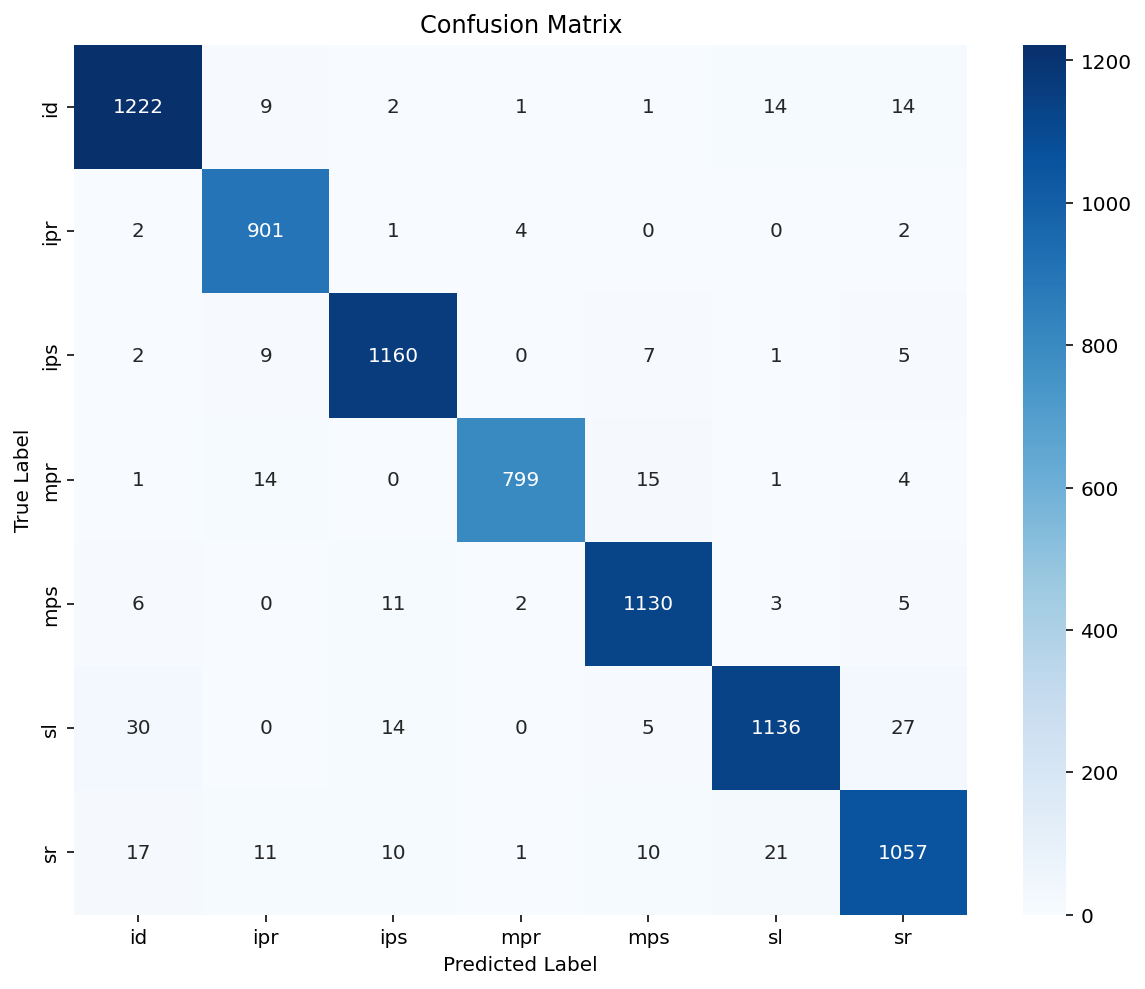

In [ ]:
#@title Visualization
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
best_model = tf.keras.models.load_model('/tmp/best_model.h5')
print(best_model.evaluate(X_test, y_test))
# Convert y_test from one-hot encoding to single class labels (for confusion matrix)
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions using the trained model
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

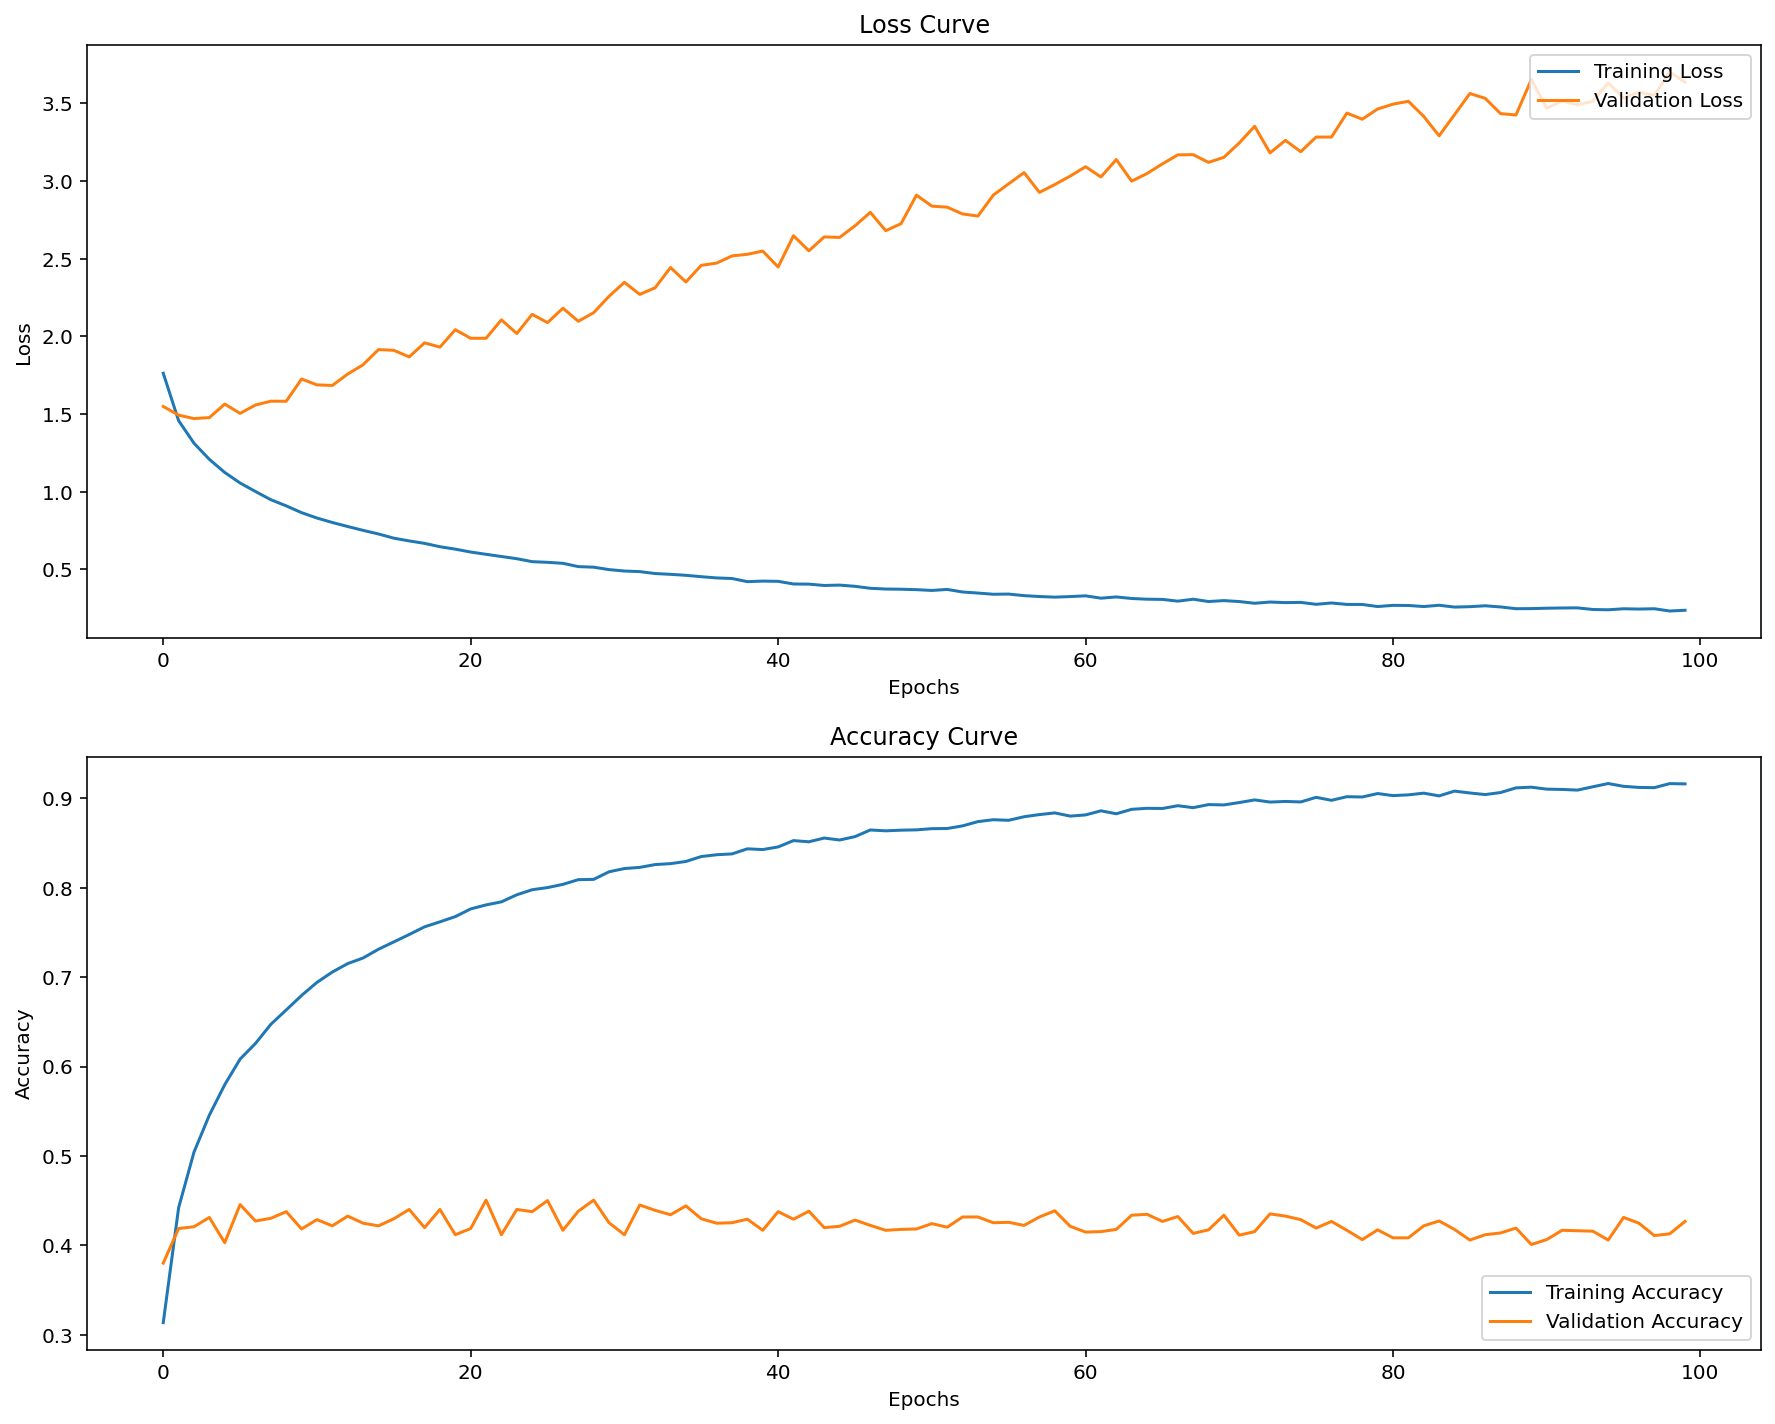

In [ ]:
#@title Plots
import matplotlib.pyplot as plt

# Assuming `history` is the variable that stores the training history from model.fit()

# Create subplots for loss and accuracy curves
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Plot the training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

# Plot the training and validation accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

# Display the plots
plt.show()

# with gfile.Open('/x20/users/ca/cadyxu/eit/microgesture/best_model.h5', 'wb') as f:
#   best_model.save(f)
gfile.Copy('/tmp/best_model.h5', '/x20/users/ca/cadyxu/eit/microgesture/best_model.h5', overwrite=True)

In [36]:
#@title LOSO

import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

is_fewshot_finetuning = True #@param{type: "boolean"}
is_whole_sesion_finetuning = True #@param{type: "boolean"}

num_epoch_train = 2 #@param
num_epoch_finetune = 10 #@param
num_window_finetune = 1 #@param

# Assume data, labels, and users (user IDs) are available from earlier preprocessing
# data: The input data (X)
# labels: The target labels (y)
# users: User or participant IDs corresponding to each data point

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(indexed_labels, num_classes=len(label_set))

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()

logo_session = LeaveOneGroupOut()

# Prepare to store accuracy from each fold
fold_accuracies = []

LOSO_result = {}

# Loop over each fold in LOSO
for train_index, test_index in logo.split(data, labels_one_hot, groups=users):
    # Split data into training and testing sets for the current fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,
    12)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_set), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Define the path to save the best model
    checkpoint_filepath = f'/tmp/{users[test_index][0]}_best_model.h5'

    # Create a ModelCheckpoint callback to save the model with the lowest validation loss
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
        verbose=1,
        save_best_only=True,
        mode='max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
    )

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=num_epoch_train, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

    if is_fewshot_finetuning:
      for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
        fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
        fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
        # print(f"LOSO session: {len(used_sessions)}")
        # print(f"LOSO session: {labels[test_index][fs_test_index]}")
        if not is_whole_sesion_finetuning:
          used_sessions = sessions[test_index][fs_test_index]
          labels_unique, unique_idx = np.unique(labels[test_index][fs_test_index], return_index=True)
          used_idx = []
          for i, idx in enumerate(unique_idx):
            used_idx.extend(list(range(idx, idx+num_window_finetune)))

          fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index][used_idx]
          fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index][used_idx]
        fs_history = model.fit(fs_X_test, fs_y_test, epochs=num_epoch_finetune, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])
        break

    # Evaluate the model
    cur_best_model = tf.keras.models.load_model(checkpoint_filepath)
    test_loss, test_acc = cur_best_model.evaluate(X_test, y_test)
    gfile.Copy(checkpoint_filepath, f'/x20/users/ca/cadyxu/eit/microgesture/{users[test_index][0]}_best_model.h5', overwrite=True)

    # Save the test accuracy for this fold
    fold_accuracies.append(test_acc)
    print(f"LOSO user: {users[test_index]}")
    print(f"Fold Accuracy: {test_acc} loss: {test_loss}")
    LOSO_result[users[test_index][0]] = (test_acc, test_loss)

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average LOSO Accuracy: {avg_accuracy}")

Epoch 1/2
1129/1133 [============================>.] - ETA: 0s - loss: 0.7916 - accuracy: 0.7024
Epoch 1: val_accuracy improved from -inf to 0.73741, saving model to /tmp/p01_best_model.h5
1133/1133 [==============================] - 5s 3ms/step - loss: 0.7911 - accuracy: 0.7026 - val_loss: 0.7189 - val_accuracy: 0.7374
Epoch 2/2
1129/1133 [============================>.] - ETA: 0s - loss: 0.5327 - accuracy: 0.8038
Epoch 2: val_accuracy did not improve from 0.73741
1133/1133 [==============================] - 3s 3ms/step - loss: 0.5324 - accuracy: 0.8038 - val_loss: 0.8099 - val_accuracy: 0.6830
Epoch 1/10
18/25 [====================>.........] - ETA: 0s - loss: 0.5296 - accuracy: 0.8490
Epoch 1: val_accuracy improved from 0.73741 to 0.94059, saving model to /tmp/p01_best_model.h5


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 11ms/step - loss: 0.4425 - accuracy: 0.8765 - val_loss: 0.1859 - val_accuracy: 0.9406
Epoch 2/10
19/25 [=====================>........] - ETA: 0s - loss: 0.2012 - accuracy: 0.9375
Epoch 2: val_accuracy did not improve from 0.94059
25/25 [==============================] - 0s 7ms/step - loss: 0.1862 - accuracy: 0.9389 - val_loss: 0.1818 - val_accuracy: 0.9374
Epoch 3/10
18/25 [====================>.........] - ETA: 0s - loss: 0.1183 - accuracy: 0.9583
Epoch 3: val_accuracy did not improve from 0.94059
25/25 [==============================] - 0s 7ms/step - loss: 0.1025 - accuracy: 0.9623 - val_loss: 0.2001 - val_accuracy: 0.9338
Epoch 4/10
18/25 [====================>.........] - ETA: 0s - loss: 0.0322 - accuracy: 0.9913
Epoch 4: val_accuracy improved from 0.94059 to 0.95193, saving model to /tmp/p01_best_model.h5
25/25 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.9896 - val_loss: 0.1487 - val_accuracy: 0.9519
Epoc

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 10ms/step - loss: 0.6045 - accuracy: 0.7832 - val_loss: 1.0633 - val_accuracy: 0.7281
Epoch 2/10
19/27 [====================>.........] - ETA: 0s - loss: 0.0906 - accuracy: 0.9671
Epoch 2: val_accuracy improved from 0.72814 to 0.75192, saving model to /tmp/p03_best_model.h5
27/27 [==============================] - 0s 9ms/step - loss: 0.0945 - accuracy: 0.9680 - val_loss: 1.0194 - val_accuracy: 0.7519
Epoch 3/10
19/27 [====================>.........] - ETA: 0s - loss: 0.0417 - accuracy: 0.9901
Epoch 3: val_accuracy improved from 0.75192 to 0.76380, saving model to /tmp/p03_best_model.h5
27/27 [==============================] - 0s 9ms/step - loss: 0.0413 - accuracy: 0.9905 - val_loss: 1.0015 - val_accuracy: 0.7638
Epoch 4/10
19/27 [====================>.........] - ETA: 0s - loss: 0.0243 - accuracy: 0.9984
Epoch 4: val_accuracy did not improve from 0.76380
27/27 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9988 - 

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 10ms/step - loss: 0.7572 - accuracy: 0.7894 - val_loss: 2.0347 - val_accuracy: 0.6178
Epoch 2/10
19/27 [====================>.........] - ETA: 0s - loss: 0.1134 - accuracy: 0.9605
Epoch 2: val_accuracy improved from 0.61783 to 0.62285, saving model to /tmp/p05_best_model.h5
27/27 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9688 - val_loss: 2.0955 - val_accuracy: 0.6229
Epoch 3/10
18/27 [===================>..........] - ETA: 0s - loss: 0.0468 - accuracy: 0.9844
Epoch 3: val_accuracy did not improve from 0.62285
27/27 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.9850 - val_loss: 2.0528 - val_accuracy: 0.6195
Epoch 4/10
19/27 [====================>.........] - ETA: 0s - loss: 0.0287 - accuracy: 0.9934
Epoch 4: val_accuracy did not improve from 0.62285
27/27 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9907 - val_loss: 2.0754 - val_accuracy: 0.6187
Epoc

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 11ms/step - loss: 0.2602 - accuracy: 0.9133 - val_loss: 0.0857 - val_accuracy: 0.9744
Epoch 2/10
19/24 [======================>.......] - ETA: 0s - loss: 0.0248 - accuracy: 0.9934
Epoch 2: val_accuracy did not improve from 0.97443
24/24 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0901 - val_accuracy: 0.9704
Epoch 3/10
18/24 [=====================>........] - ETA: 0s - loss: 0.0085 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.97443 to 0.98520, saving model to /tmp/p07_best_model.h5
24/24 [==============================] - 0s 8ms/step - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.0548 - val_accuracy: 0.9852
Epoch 4/10
19/24 [======================>.......] - ETA: 0s - loss: 0.0099 - accuracy: 0.9984
Epoch 4: val_accuracy did not improve from 0.98520
24/24 [==============================] - 0s 7ms/step - loss: 0.0093 - accuracy: 0.9987 - val_loss: 0.0624 - val_accuracy: 0.9807
Epoc

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 11ms/step - loss: 0.8163 - accuracy: 0.7353 - val_loss: 0.4763 - val_accuracy: 0.8287
Epoch 2/10
17/24 [====================>.........] - ETA: 0s - loss: 0.1833 - accuracy: 0.9375
Epoch 2: val_accuracy improved from 0.82874 to 0.85418, saving model to /tmp/p09_best_model.h5
24/24 [==============================] - 0s 9ms/step - loss: 0.1679 - accuracy: 0.9410 - val_loss: 0.4098 - val_accuracy: 0.8542
Epoch 3/10
18/24 [=====================>........] - ETA: 0s - loss: 0.0832 - accuracy: 0.9722
Epoch 3: val_accuracy improved from 0.85418 to 0.85460, saving model to /tmp/p09_best_model.h5
24/24 [==============================] - 0s 9ms/step - loss: 0.0846 - accuracy: 0.9712 - val_loss: 0.4646 - val_accuracy: 0.8546
Epoch 4/10
17/24 [====================>.........] - ETA: 0s - loss: 0.0625 - accuracy: 0.9816
Epoch 4: val_accuracy did not improve from 0.85460
24/24 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9869 - 

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 0s 11ms/step - loss: 0.6114 - accuracy: 0.7478 - val_loss: 0.9082 - val_accuracy: 0.7135
Epoch 2/10
17/26 [==================>...........] - ETA: 0s - loss: 0.1696 - accuracy: 0.9357
Epoch 2: val_accuracy improved from 0.71351 to 0.72399, saving model to /tmp/p11_best_model.h5
26/26 [==============================] - 0s 9ms/step - loss: 0.1510 - accuracy: 0.9476 - val_loss: 1.0121 - val_accuracy: 0.7240
Epoch 3/10
18/26 [===================>..........] - ETA: 0s - loss: 0.2566 - accuracy: 0.9167
Epoch 3: val_accuracy improved from 0.72399 to 0.74664, saving model to /tmp/p11_best_model.h5
26/26 [==============================] - 0s 9ms/step - loss: 0.2392 - accuracy: 0.9189 - val_loss: 0.9948 - val_accuracy: 0.7466
Epoch 4/10
17/26 [==================>...........] - ETA: 0s - loss: 0.1945 - accuracy: 0.9338
Epoch 4: val_accuracy did not improve from 0.74664
26/26 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.9376 - 

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 10ms/step - loss: 0.3185 - accuracy: 0.8818 - val_loss: 0.2083 - val_accuracy: 0.9309
Epoch 2/10
18/25 [====================>.........] - ETA: 0s - loss: 0.0776 - accuracy: 0.9740
Epoch 2: val_accuracy improved from 0.93091 to 0.94185, saving model to /tmp/p13_best_model.h5
25/25 [==============================] - 0s 9ms/step - loss: 0.0681 - accuracy: 0.9799 - val_loss: 0.1945 - val_accuracy: 0.9418
Epoch 3/10
17/25 [===================>..........] - ETA: 0s - loss: 0.0351 - accuracy: 0.9871
Epoch 3: val_accuracy improved from 0.94185 to 0.94884, saving model to /tmp/p13_best_model.h5
25/25 [==============================] - 0s 9ms/step - loss: 0.0331 - accuracy: 0.9874 - val_loss: 0.1816 - val_accuracy: 0.9488
Epoch 4/10
17/25 [===================>..........] - ETA: 0s - loss: 0.0149 - accuracy: 0.9982
Epoch 4: val_accuracy did not improve from 0.94884
25/25 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9962 - 

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 11ms/step - loss: 0.5524 - accuracy: 0.8369 - val_loss: 1.5308 - val_accuracy: 0.7188
Epoch 2/10
18/28 [==================>...........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9826
Epoch 2: val_accuracy improved from 0.71884 to 0.73118, saving model to /tmp/p17_best_model.h5
28/28 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.9875 - val_loss: 1.6035 - val_accuracy: 0.7312
Epoch 3/10
18/28 [==================>...........] - ETA: 0s - loss: 0.0436 - accuracy: 0.9861
Epoch 3: val_accuracy improved from 0.73118 to 0.73238, saving model to /tmp/p17_best_model.h5
28/28 [==============================] - 0s 8ms/step - loss: 0.0345 - accuracy: 0.9909 - val_loss: 1.7110 - val_accuracy: 0.7324
Epoch 4/10
18/28 [==================>...........] - ETA: 0s - loss: 0.0243 - accuracy: 0.9931
Epoch 4: val_accuracy did not improve from 0.73238
28/28 [==============================] - 0s 7ms/step - loss: 0.0199 - accuracy: 0.9955 - 

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/tf_keras/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
print(LOSO_result)

{'p01': (0.9523809552192688, 0.15266242623329163), 'p02': (0.8068221211433411, 0.6373773813247681), 'p03': (0.7638036608695984, 1.001463770866394), 'p04': (0.6289504766464233, 2.19685959815979), 'p05': (0.6462955474853516, 2.0592546463012695), 'p06': (0.9015747904777527, 0.4506351053714752), 'p07': (0.9851951599121094, 0.05482601374387741), 'p08': (0.8583902716636658, 0.7034732103347778), 'p09': (0.8545994162559509, 0.46459412574768066), 'p10': (0.9377756118774414, 0.39813387393951416), 'p11': (0.7692952752113342, 1.0149118900299072), 'p12': (0.8389319777488708, 0.9226244688034058), 'p13': (0.9488412737846375, 0.1816251128911972), 'p15': (0.9360436201095581, 0.2167278528213501), 'p17': (0.7335723042488098, 1.7581895589828491), 'p18': (0.7887014150619507, 0.738665759563446)}


In [ ]:
s = 0
LOSO_result = {'p01': (0.9528344869613647, 0.16405019164085388), 'p02': (0.7577444911003113, 0.7960899472236633), 'p03': (0.7227760553359985, 1.1477067470550537), 'p04': (0.5872024893760681, 2.2566452026367188), 'p05': (0.6082042455673218, 2.2526490688323975), 'p06': (0.8031495809555054, 0.6562409400939941), 'p07': (0.9654553532600403, 0.11427630484104156), 'p08': (0.809415340423584, 0.8559161424636841), 'p09': (0.7651547193527222, 0.9676390886306763), 'p10': (0.9372856616973877, 0.31781259179115295), 'p11': (0.7516778707504272, 1.0017585754394531), 'p12': (0.8199827671051025, 0.7012150883674622), 'p13': (0.9400961995124817, 0.19059719145298004), 'p14': (0.6351187825202942, 1.7293838262557983), 'p15': (0.925632119178772, 0.23387791216373444)}



for p, (acc, loss) in LOSO_result.items():
  if '03' in p or '04' in p or '05' in p or '14' in p or '11' in p:
  # if '04' in p or '14' in p:
    continue
  s += acc

print(s/10)

0.8676750719547272
